# Entrega Final

Los objetivos de este fichero son:

- Crear un modelo y realizar las predicciones sobre Estimar dataset, a partir los aprendizajes de anteriores notebooks

El modelo que se crea a continuación se explica en detalle en el pdf adjunto.



### Imports

In [1]:
import pandas as pd

import numpy as np

import xgboost as xgb

from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score
#from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.model_selection import train_test_split

from imblearn.combine import SMOTETomek

from sklearn.multiclass import OneVsRestClassifier
#from sklearn.multiclass import OneVsOneClassifier
#from sklearn import svm

import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

from scipy.special import softmax

import sys; sys.path.insert(0, '..')
import lib

### Load Data

In [2]:
X_modelar, y_modelar = lib.readHDF('../../Data/raw/hdf5/data.hdf5')
X_estimar = lib.readHDF('../../Data/raw/hdf5/data.hdf5',estimar = True)

In [3]:
X_full = pd.concat([X_modelar, X_estimar], sort=False)

est_ID = X_estimar['ID']

### Añadir dimensiones contexto

Primero va a añadir al dataset una dimensión por cada clase (menos RESIDENTIAL), en la que los valores mostrarán la cantidad de fincas vecinas a dicha finca según la clase.

Si dicha finca vecina esta en el set Modelar, conocemos la verdadera Clase. Si la finca se encuentra en el set Estimar, entonces se sumará la probabilidad de dicha clase

A continuación se crea un cKDTree, una estructura que organiza las fincas según las cordenadas X, Y y nos permite hacer consultas más adelante para obtener los vecinos de cada finca

In [4]:
X_spatial = X_full[['X','Y']]

spatialTree = cKDTree(np.c_[X_spatial.X.ravel(),X_spatial.Y.ravel()])

- Se eliminan las variables ID, X , Y de los data sets
- Variables categóricas a numéricas
- Se eliminan déciles que se consideran que no aportan información adicional

In [5]:
X_full.drop(['ID','X','Y'],inplace=True,axis=1)
X_full = lib.cadastralQualityToNumeric(X_full)
X_full = lib.buildingFloorToNumeric(X_full)
X_full = lib.deleteRedundantChannels(X_full)

X_estimar.drop(['ID','X','Y'],inplace=True,axis=1)
X_estimar = lib.cadastralQualityToNumeric(X_estimar)
X_estimar = lib.buildingFloorToNumeric(X_estimar)
X_estimar = lib.deleteRedundantChannels(X_estimar)

X_modelar.drop(['ID','X','Y'],inplace=True,axis=1)
X_modelar = lib.cadastralQualityToNumeric(X_modelar)
X_modelar = lib.buildingFloorToNumeric(X_modelar)
X_modelar = lib.deleteRedundantChannels(X_modelar)

Este clasificador se va a utilizar para predecir las probabilidades de que una finca pertenecezca a cada clase. 



In [6]:
model = xgb.XGBClassifier(random_state=420,tree_method='gpu_hist',objective="binary:logistic",eval_metric="logloss", 
                      #eval_set=eval_set, 
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=8,
                      gamma=0.005,
                      reg_alpha=0.05,
                      reg_lambda=1.0,
                     # early_stopping_rounds=20
                    )

clf0 = OneVsRestClassifier(model,n_jobs=12).fit(X_modelar,y_modelar)

In [7]:
pred_estimar = clf0.predict_proba(X_estimar)

In [8]:
clf0.classes_

array(['AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC',
       'RESIDENTIAL', 'RETAIL'], dtype='<U11')

Iteramos por cada finca en Modelar y Estimar.

Para cada una obtenemos las 3 (K - 1) fincas vecinas y computamos las variables contexto

In [9]:
K = 4 # Num. de vecinos menos uno porque el primero es la propia finca

offset = X_modelar.shape[0]
y_map = {'RESIDENTIAL':5,'INDUSTRIAL':1,'PUBLIC':4,'RETAIL':6,'OFFICE':2,'OTHER':3,'AGRICULTURE':0}

col_names = []

for i in range(7):
    col_names.append(str('contexto_'+clf0.classes_[i]))

tmp_concat = [] # Por eficiencia, el coste de concatenacion de un df en el for es cuadratico

for i in range(X_full.shape[0]):
    
    #Inicializamos las variables contexto
    tmp = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    
    #Obtenemos los vecinos
    vecinos_dist, vecinos_indices = spatialTree.query([[X_spatial.iloc[i,0],X_spatial.iloc[i,1]]],k=K)
    
    for j in range(1,K):
        # Para cada vecino sumamos 1 a la variable contexto de la clase de la finca 
        # O en caso de que se encuentre en X_estimar sumamos las probabilidades
        if vecinos_indices[0][j] < offset : 
            tmp[y_map[y_modelar[j]]] = tmp[y_map[y_modelar[j]]] + 1       
        else:
            tmp = np.add(tmp, pred_estimar[vecinos_indices[0][j]-offset,:])

    tmp_concat.append(tmp)# Probar con softmax tmb

contexto  = pd.DataFrame(tmp_concat,columns=col_names)
print(contexto.shape)
print(X_full.shape)
contexto.head(20)

(108848, 7)
(108848, 24)


,contexto_AGRICULTURE,contexto_INDUSTRIAL,contexto_OFFICE,contexto_OTHER,contexto_PUBLIC,contexto_RESIDENTIAL,contexto_RETAIL
0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
9,0.002115,0.948188,0.005201,0.000717,0.003418,2.024537,0.015824


Creamos los nuevos datasets con las vadriables contexto añadidas

In [10]:
X_modelar2 = pd.concat([X_modelar,contexto[:X_modelar.shape[0]].reindex(X_modelar.index)], axis = 1, sort = False)
X_estimar2 = pd.concat([X_estimar, contexto[X_modelar.shape[0]:].reindex(X_estimar.index)], axis = 1, sort = False)
print(X_modelar2.shape)
print(X_estimar2.shape)

(103230, 31)
(5618, 31)


Para confirmar que existe una correlación entre las clases y las variables contexto, hacemos una pequeña prueba obteniendo las medias y quartiles de dichas variables según cada clase

In [11]:
Xy = pd.concat([X_modelar2,y_modelar], axis = 1, sort = False)

g = Xy.groupby('CLASE')
for var in Xy.columns[24:31]:
    print('VARIABLE: ', var)
    print(g[var].describe().drop(columns=['count','std','min']))

VARIABLE:  contexto_AGRICULTURE
                 mean  25%  50%       75%       max
CLASE                                              
AGRICULTURE  0.143134  0.0  0.0  0.043068  1.544359
INDUSTRIAL   0.002417  0.0  0.0  0.000144  0.688718
OFFICE       0.000416  0.0  0.0  0.000000  0.105328
OTHER        0.000325  0.0  0.0  0.000000  0.158705
PUBLIC       0.001772  0.0  0.0  0.000000  0.888890
RESIDENTIAL  0.000230  0.0  0.0  0.000000  0.894192
RETAIL       0.001170  0.0  0.0  0.000000  0.758736
VARIABLE:  contexto_INDUSTRIAL
                 mean  25%  50%       75%       max
CLASE                                              
AGRICULTURE  0.106096  0.0  0.0  0.036482  1.621692
INDUSTRIAL   0.209885  0.0  0.0  0.099606  2.726154
OFFICE       0.055698  0.0  0.0  0.000000  2.282067
OTHER        0.019645  0.0  0.0  0.000000  1.388525
PUBLIC       0.019112  0.0  0.0  0.000000  1.809043
RESIDENTIAL  0.007231  0.0  0.0  0.000000  1.949833
RETAIL       0.031700  0.0  0.0  0.000000  1.397591
V

Eliminamos contexto_RESIDENTIAL

In [12]:
contexto.drop('contexto_RESIDENTIAL',axis=1,inplace=True)

### Crear y testear el modelo

El siguiente modelo se explica más en detalle en el documento adjunto.

Sigue el modelo propuesto en el siguiente paper:

Enhancing classification performance of multi-class imbalanced data using the OAA-DB algorithm
https://www.researchgate.net/publication/261086899

Las principales diferencias con el modelo del paper es que se ha utilizazo Decission Trees en vez de redes neuronales y para el balanceamiento de los datos, la técnica de oversampling es la misma SMOTE pero la tecnica de undersampling es la eliminación de los Tomek links en vez de la red neuronal complementaria de veracidad y falsedad propuesta en el paper. Esta elección se ha hecho por simplicidad.


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_modelar2,y_modelar,test_size = 0.2,shuffle=True)

El primer clasificador usa el dataset sin balancear, creado en la sección anterior con las variables contexto.

In [ ]:
#eval_set = [(X_train, y_train), (X_test, y_test)]

model = xgb.XGBClassifier(random_state=420,tree_method='gpu_hist',objective="binary:logistic",eval_metric="logloss", 
                      #eval_set=eval_set, 
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=10,
                      gamma=0.005,
                      reg_alpha=0.05,
                      reg_lambda=1.0,
                     # early_stopping_rounds=20
                    )

clf1 = OneVsRestClassifier(model,n_jobs=3).fit(X_train,y_train)

In [16]:
pred = clf1.predict(X_test)

       f1  precision    recall  accuracy
0  0.5127   0.913204  0.913204  0.913204


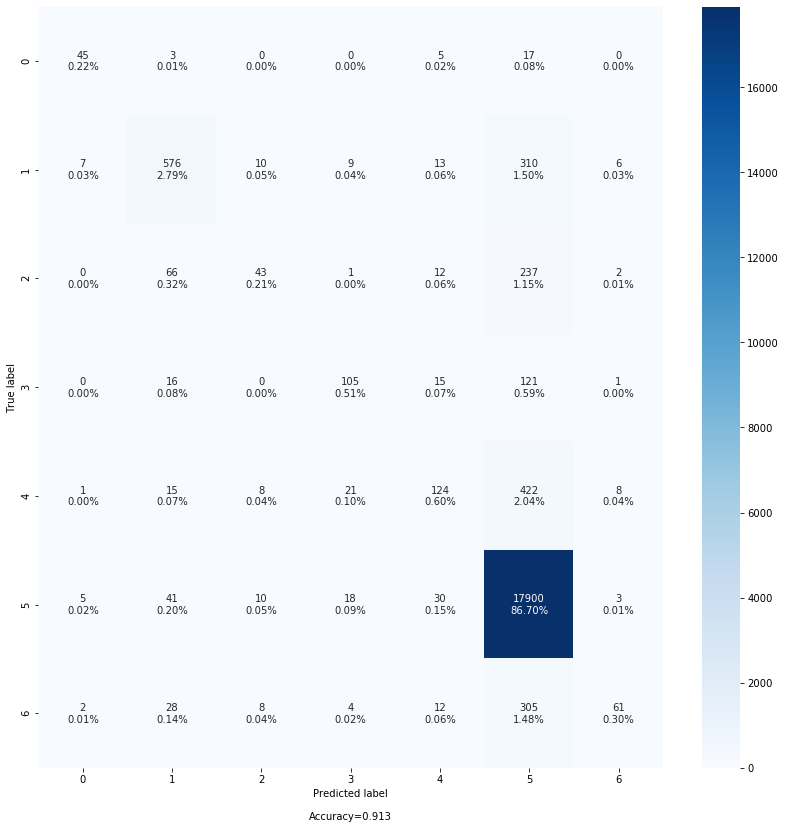

In [17]:
scores = []

scores.append((f1_score(y_test,pred,average='macro'), precision_score(y_test,pred,average='micro'), recall_score(y_test,pred,average='micro'), accuracy_score(y_test,pred)))

results = pd.DataFrame(scores,columns=['f1','precision','recall','accuracy'])

print(results)

lib.make_confusion_matrix(confusion_matrix(y_test,pred), figsize=(14,14), cbar=True)

A continuación se crea el dataset balanceado para el segundo clasificador, este dataset no contiene las variables contexto

In [18]:
print(X_train.shape[0])
print(y_train.shape[0])
#sampling_strategy=over_dict
transformer = SMOTETomek(n_jobs=12)
X_train2 = X_train.drop(X_train.columns[24:31],inplace=False,axis=1)
X_test2 = X_test.drop(X_test.columns[24:31],inplace=False,axis=1)
X_smote, y_smote = transformer.fit_resample(X_train2, y_train)
print(X_smote.shape[0])
print(y_smote.shape[0])

82584
82584
479754
479754


Se entrena al segundo clasificador sobre los datos balanceados

In [19]:
#X_smote, X_smote_test, y_smote, y_smote_test = train_test_split(X_train2,y_train2,test_size = 0.2,shuffle=True)
#eval_set = [(X_smote, y_smote), (X_smote_test, y_smote_test)]


#n_jobs = X a veces da un problema de concurrencia diff a un memory overflow
#modelB = clf2 = svm.SVC(kernel='rbf')
clf2 = OneVsRestClassifier(model, n_jobs=3).fit(X_smote,y_smote)
#clf3 = OneVsOneClassifier(modelB).fit(X_smote,y_smote)

In [20]:
pred = clf2.predict(X_test2)

         f1  precision    recall  accuracy
0  0.456556   0.767461  0.767461  0.767461


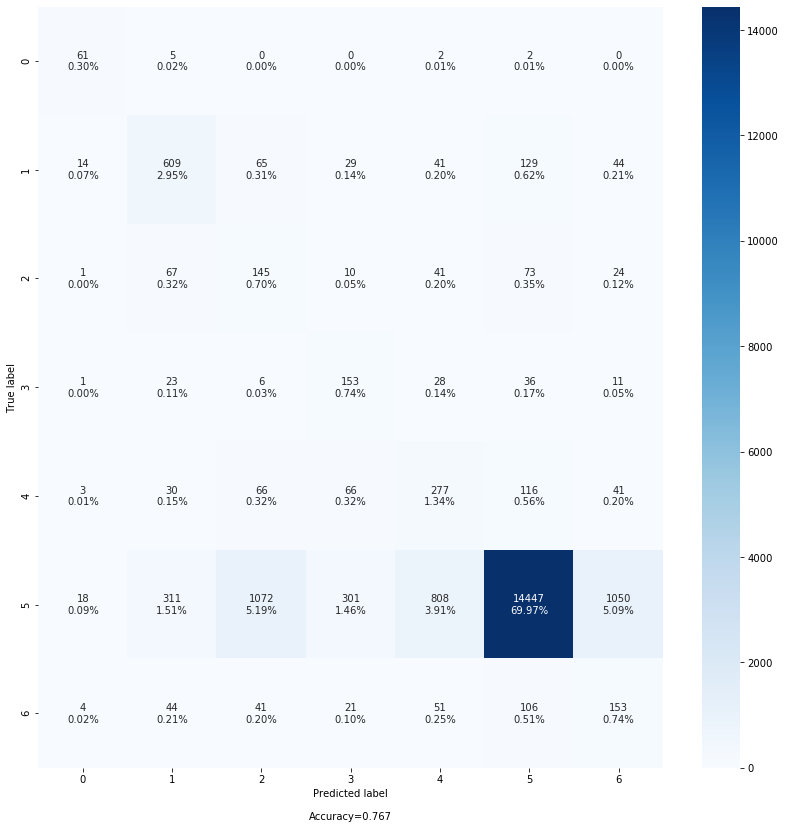

In [21]:
scores = []

scores.append((f1_score(y_test,pred,average='macro'), precision_score(y_test,pred,average='micro'), recall_score(y_test,pred,average='micro'), accuracy_score(y_test,pred)))

results = pd.DataFrame(scores,columns=['f1','precision','recall','accuracy'])

print(results)

lib.make_confusion_matrix(confusion_matrix(y_test,pred), figsize=(14,14), cbar=True)

### Modelo predicción final según los dos clasificadores

A continuación se define la función que realiza las predicciónes sefun el algoritmo propuesto en el paper y que esta explicado en detalle en el documento adjunto.

Se adjunta una imagen flowchart para entenderlo más fácil.

Principales diferencias:
- Undersampling mediante Tomek Links en vez de CMTNN
- Threshold del primer clasificador en 15% en vez de 50%

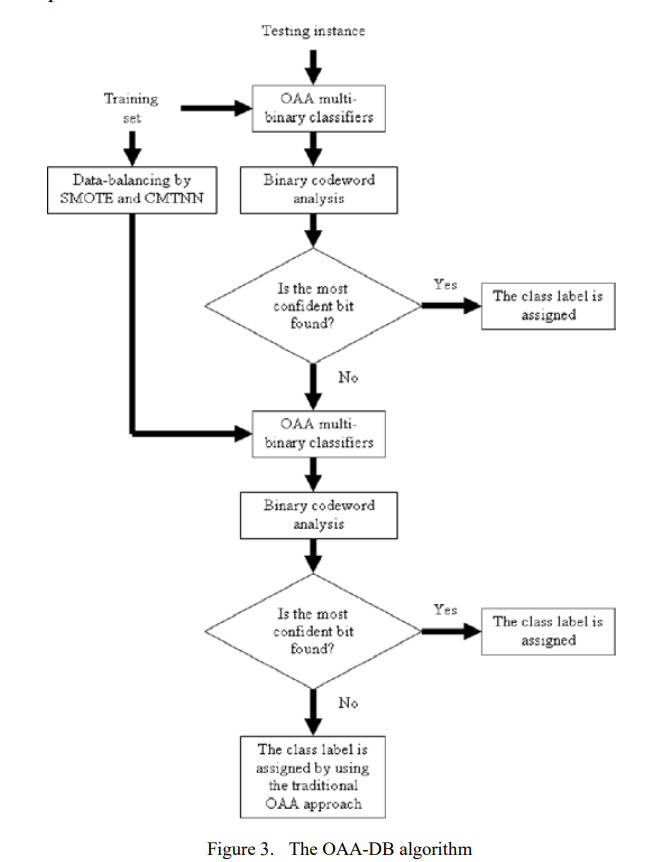

In [22]:
def finalPrediction(X_test):
    
    print(clf1.classes_)
    
    # Predicciones según el primer clasificador
    predA = clf1.predict_proba(X_test)
    
    # Predicciones según el segundo clasificador
    X_test2 = X_test.drop(X_test.columns[24:31],inplace=False,axis=1)
    predB = clf2.predict_proba(X_test2)

    probNames = clf1.classes_
    
    # Estas variables las uso para saber cuantas predicciones se han hecho en cada fase
    c1=0
    c2=0
    c3=0

    predFinal = []
    
    # Para cada observación a predecir
    for i in range(X_test.shape[0]):
        tmp1 = []
        for j in range(7):
            # Añadimos a tmp1 las clases con mas de un 15% de probabilidad
            # según el primer clasificador
            if predA[i,j] > 0.15:
                tmp1.append(probNames[j])
                
        # Si solo hay una clase ya tenemos predicción
        if  len(tmp1) == 1:
            predFinal.append(tmp1[0])
            c1+=1
        else:
            tmp2 = []
            for j in range(7):
                # Añadimos a tmp2 las clases con mas de un 50% de probabilidad
                # según el segundo clasificador
                if predB[i,j] > 0.5:
                    tmp2.append(probNames[j])
                    
            # Si solo hay una clase ya tenemos predicción
            if  len(tmp2) == 1:
                predFinal.append(tmp2[0])
                c2+=1
            # Sino la predicción es la clase con más probabilidad según el primer clasificador
            else:
                max_index = np.argmax(predA[i,:])
                predFinal.append(probNames[max_index])
                c3+=1
                    
    print('Predicciones en fase 1',c1)
    print('Predicciones en fase 2',c2)
    print('Predicciones vuelta a fase 1',c3)
    
    return predFinal

['AGRICULTURE' 'INDUSTRIAL' 'OFFICE' 'OTHER' 'PUBLIC' 'RESIDENTIAL'
 'RETAIL']
19365
1040
241
         f1  precision    recall  accuracy
0  0.831944   0.958588  0.958588  0.958588


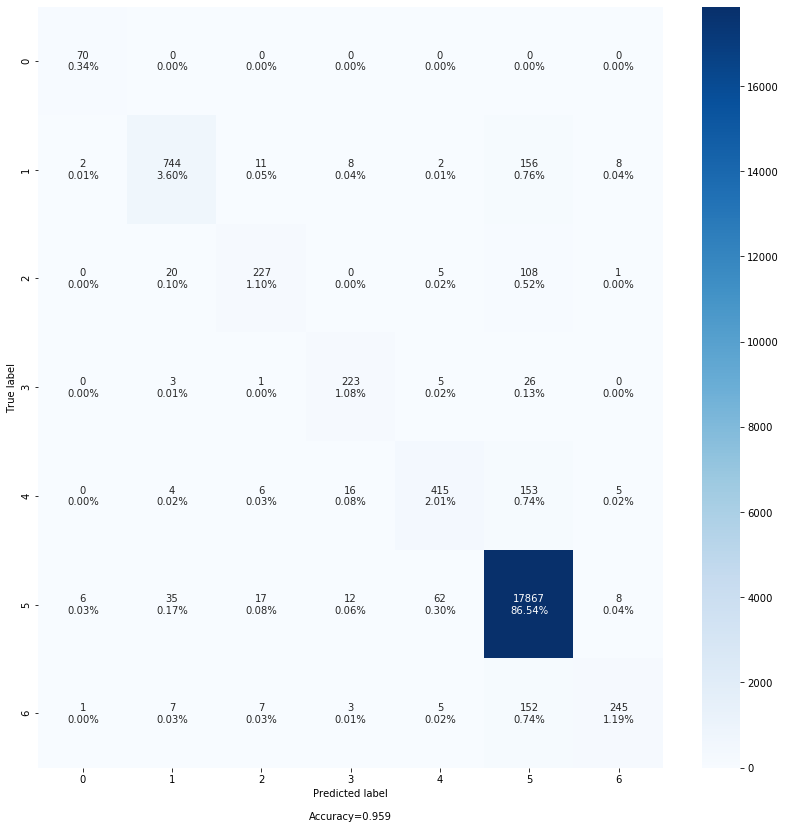

In [39]:
pred = finalPrediction(X_test)

scores = []


scores.append((f1_score(y_test,pred,average='macro'), precision_score(y_test,pred,average='micro'), recall_score(y_test,pred,average='micro'), accuracy_score(y_test,pred)))

results = pd.DataFrame(scores,columns=['f1','precision','recall','accuracy'])

print(results)

lib.make_confusion_matrix(confusion_matrix(y_test,pred), figsize=(14,14), cbar=True)

El siguiente apartado lo uso para ver probabilidades y ver como se comporta el algoritmo, no tiene mucha importancia

In [24]:
predA = clf1.predict_proba(X_test)
predB = clf2.predict_proba(X_test2)

df_predA = pd.DataFrame(predA,columns=clf1.classes_)
df_predB = pd.DataFrame(predB,columns=clf2.classes_)

In [25]:
y_test.head(20)

279      RESIDENTIAL
46772         PUBLIC
81457    RESIDENTIAL
19715    RESIDENTIAL
7390     RESIDENTIAL
89753    RESIDENTIAL
34192     INDUSTRIAL
9848     RESIDENTIAL
26638    RESIDENTIAL
6186     RESIDENTIAL
4809     RESIDENTIAL
35537    RESIDENTIAL
95773    RESIDENTIAL
69160    RESIDENTIAL
83510    RESIDENTIAL
3730      INDUSTRIAL
11675         RETAIL
74162    RESIDENTIAL
28909    RESIDENTIAL
94344    RESIDENTIAL
Name: CLASE, dtype: category
Categories (7, object): [AGRICULTURE, INDUSTRIAL, OFFICE, OTHER, PUBLIC, RESIDENTIAL, RETAIL]

In [26]:
df_predA.head(20)

,AGRICULTURE,INDUSTRIAL,OFFICE,OTHER,PUBLIC,RESIDENTIAL,RETAIL
0,0.000250,0.001046,0.000253,0.000318,0.000596,0.996076,0.001461
1,0.000094,0.006800,0.037084,0.025699,0.093949,0.833703,0.002672
2,0.000061,0.002421,0.000432,0.000798,0.001369,0.992635,0.002284
3,0.000045,0.001963,0.001822,0.006059,0.003407,0.980408,0.006296
4,0.000060,0.014332,0.001498,0.000525,0.002333,0.978719,0.002534
5,0.000061,0.005230,0.001802,0.000590,0.003144,0.963339,0.025834
6,0.000248,0.819589,0.039929,0.007737,0.034022,0.054099,0.044376
7,0.000176,0.002650,0.001098,0.000242,0.002230,0.990101,0.003504
8,0.000293,0.028415,0.003272,0.001896,0.031456,0.915994,0.018674
9,0.000056,0.032950,0.073498,0.020269,0.154960,0.695357,0.022910


In [27]:
df_predB.head(20)

,AGRICULTURE,INDUSTRIAL,OFFICE,OTHER,PUBLIC,RESIDENTIAL,RETAIL
0,0.000732,0.004486,0.000448,0.001668,0.001513,0.978470,0.012682
1,0.000048,0.006895,0.039602,0.115044,0.389514,0.445955,0.002942
2,0.000033,0.015465,0.000463,0.006377,0.002319,0.949706,0.025637
3,0.000038,0.011533,0.026670,0.189120,0.019162,0.583195,0.170282
4,0.000063,0.081584,0.019137,0.001720,0.011259,0.841580,0.044658
5,0.000070,0.049398,0.018295,0.003259,0.008598,0.626977,0.293402
6,0.000066,0.784329,0.089428,0.007319,0.044252,0.002403,0.072202
7,0.000343,0.023692,0.005831,0.000609,0.044150,0.908568,0.016806
8,0.000629,0.065098,0.047585,0.007058,0.318119,0.421460,0.140051
9,0.000044,0.064366,0.226725,0.035783,0.501820,0.073294,0.097968


### Final Fit con todos los datos y creamos la entrega

In [29]:
model = xgb.XGBClassifier(random_state=420,tree_method='gpu_hist',objective="binary:logistic",eval_metric="logloss", 
                      #eval_set=eval_set, 
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=10,
                      gamma=0.005,
                      reg_alpha=0.05,
                      reg_lambda=1.0,
                     # early_stopping_rounds=20
                    )

clf1 = OneVsRestClassifier(model,n_jobs=3).fit(X_modelar2,y_modelar)

transformer = SMOTETomek(n_jobs=12)
X_smote, y_smote = transformer.fit_resample(X_modelar, y_modelar)

clf2 = OneVsRestClassifier(model,n_jobs=3).fit(X_smote,y_smote)

In [35]:
pred = finalPrediction(X_estimar2)

['AGRICULTURE' 'INDUSTRIAL' 'OFFICE' 'OTHER' 'PUBLIC' 'RESIDENTIAL'
 'RETAIL']
4475
923
220


In [36]:
entrega = pd.DataFrame()
entrega['ID'] = est_ID
entrega['CLASE'] = pred

In [37]:
entrega.shape

(5618, 2)

In [38]:
entrega.head()

,ID,CLASE
0,44198C2A811A4DF4,RESIDENTIAL
1,216F638609E0E39E,RESIDENTIAL
2,FFFCEFB11E257364,RESIDENTIAL
3,596C5C8CE10BCF,OFFICE
4,F931B9FA2A8641D1,OTHER


In [34]:
entrega.to_csv('../../Data/entrega2/Minsait_Universidad Politecnica de Valencia_Sigma_69.txt',index = False, header=True,sep='|',encoding='utf-8-sig')

### Otros modelos

La idea es probar otros modelos como SVM, KNN, redes neuronales... y combinarlos mediante stacking, bagging o ensemble para obtener un modelo más preciso y robusto.

Para esta entrega he llegado a tiempo a si que no tener en cuenta lo expuesto a continuación.

De entre todos los modelos que se han probado de forma independiente siempre XGBoost ha obtenido mejores resultados.

En un futuro probar otras librerias de Decission Trees como LightGBM, CatBoost...

### SVM

Mejor kernel rbf. Malos resultados. Probar para el segundo nivel del clasificador

### Redes neuronales

Se ha probado a utilizar la librería open-source AutoKeras con la cual se ha llegado a conseguir un 88% de accuracy.

Con redes neuronales propias usando tensorflow2 se ha conseguido un 66% de accuracy.

### Knn

Con NCA da un resultado un 1-2% peor

In [54]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_modelar, y_modelar ,stratify=y_modelar, test_size=0.2, random_state=42)

In [56]:
knn = KNeighborsClassifier(n_neighbors=7)

In [57]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [58]:
print(knn.score(X_test, y_test))

0.8908747457134554


         f1  precision    recall  accuracy
0  0.394679   0.890875  0.890875  0.890875


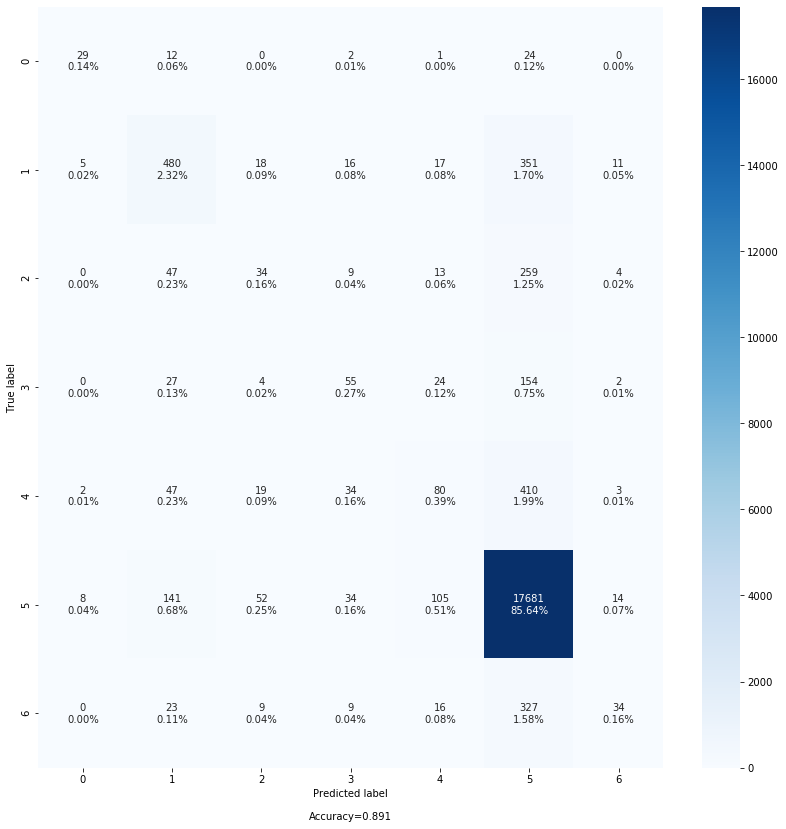

In [59]:
pred = knn.predict(X_test)

scores = []

scores.append((f1_score(y_test,pred,average='macro'), precision_score(y_test,pred,average='micro'), recall_score(y_test,pred,average='micro'), accuracy_score(y_test,pred)))

results = pd.DataFrame(scores,columns=['f1','precision','recall','accuracy'])

print(results)

lib.make_confusion_matrix(confusion_matrix(y_test,pred), figsize=(14,14), cbar=True)